In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [2]:
import sys, os

## Load in the data

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
# map inputs to (-1, +1) for better training
x_train, x_test = x_train/255.0 * 2 - 1, x_test/255.0 * 2 - 1

In [6]:
x_train.shape

(60000, 28, 28)

In [8]:
# Flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [9]:
x_train.shape

(60000, 784)

## Build the models

In [10]:
# dimensionality of the latent space
LATENT_DIM = 100

In [11]:
# generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim, ))
    x = Dense(units=256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(units=512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(units=1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)
    
    model = Model(i, x)
    return model

In [12]:
# discriminator model
def build_discriminator(img_size):
    i = Input(shape=(img_size, ))
    x = Dense(units=512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(units=256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(i, x)
    return model

## Compile the models in preparation for training

In [13]:
# build and compile the discriminator 
discriminator = build_discriminator(D)

discriminator.compile(loss='binary_crossentropy',
                     optimizer=Adam(0.0002, 0.5),
                     metrics=['accuracy'])

In [14]:
# build and compile the combined model
generator = build_generator(LATENT_DIM)

In [15]:
# create and input to represent noise sample from latent space
z = Input(shape=(LATENT_DIM, ))

# pass the noise through generator to get an image 
img = generator(z)

# make sure only the generator is trained
discriminator.trainable = False

# the true output is fake, but we label them real
fake_pred = discriminator(img)

In [16]:
# create the combined model object
combined_model = Model(z, fake_pred)

In [17]:
# compile the combined model
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [18]:
combined_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_1 (Functional)        (None, 784)               1493520   
                                                                 
 model (Functional)          (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


## Train the GAN

In [19]:
# config
BATCH_SIZE = 32
EPOCHS = 30000
SAMPLE_PERIOD = 200 # every 'sample_period' steps generate and save some data


In [20]:
# create batch labels to use when calling train on batch
ones = np.ones(BATCH_SIZE)
zeros = np.zeros(BATCH_SIZE)

In [21]:
# store the losses
d_losses = []
g_losses = []

In [22]:
# create a folder to store generated images
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [23]:
# A function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows*cols, LATENT_DIM)
    imgs = generator.predict(noise)
    
    # rescale images 0-1
    imgs = 0.5 * imgs + 0.5
    
    fig, axs = plt.subplots(rows, cols)
    
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i, j].axis('off')
            idx += 1
            
    fig.savefig('gan_images/%d.png' %epoch)
    plt.close()

In [25]:
# main training loop
for epoch in range(EPOCHS):
    ####### train discriminator ##########
    # select random batch of images
    idx = np.random.randint(0, x_train.shape[0], BATCH_SIZE)
    real_imgs = x_train[idx]
    
    # generate fake images
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    fake_imgs = generator.predict(noise)
    
    # train the discriminator
    # both loss and accuracy are returned
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)
    
    ######### train generator ###########
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    # do it again!
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    # save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{EPOCHS}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    
    if epoch % SAMPLE_PERIOD == 0:
        sample_images(epoch)
    

1/1 [==============================] - 0s 13ms/step
epoch: 1/30000, d_loss: 0.49,       d_acc: 0.52, g_loss: 0.38
1/1 [==============================] - 0s 16ms/step
epoch: 101/30000, d_loss: 0.06,       d_acc: 1.00, g_loss: 3.24
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 201/30000, d_loss: 0.79,       d_acc: 0.56, g_loss: 1.24
1/1 [==============================] - 0s 14ms/step
epoch: 301/30000, d_loss: 0.74,       d_acc: 0.41, g_loss: 0.62
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 401/30000, d_loss: 0.70,       d_acc: 0.48, g_loss: 0.64
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 501/30000, d_loss: 0.71,       d_acc: 0.48, g_loss: 0.63
1/1 [==============================] - 0s 16ms/step
epoch: 601/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.68
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 701/30000, d_loss: 0.69,       d_acc: 0.53, g_loss: 0.68
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 12ms/step
epoch: 801/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.70
1/1 [==============================] - 0s 14ms/step
epoch: 901/30000, d_loss: 0.66,       d_acc: 0.64, g_loss: 0.69
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 1001/30000, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.72
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 1101/30000, d_loss: 0.66,       d_acc: 0.58, g_loss: 0.72
1/1 [==============================] - 0s 15ms/step
epoch: 1201/30000, d_loss: 0.67,       d_acc: 0.62, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 1301/30000, d_loss: 0.66,       d_acc: 0.66, g_loss: 0.83
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 1401/30000, d_loss: 0.64,       d_acc: 0.62, g_loss: 0.80
1/1 [==============================] - 0s 15ms/step
epoch: 1501/30000, d_loss: 0.65,       d_acc: 0.67, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 1601/30000, d_loss: 0.68,       d_acc: 0.52, g_loss: 0.80
1/1 [==============================] - 0s 13ms/step
epoch: 1701/30000, d_loss: 0.62,       d_acc: 0.69, g_loss: 0.83


1/1 [==============================] - 0s 14ms/step
epoch: 1801/30000, d_loss: 0.65,       d_acc: 0.58, g_loss: 0.80
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 1901/30000, d_loss: 0.69,       d_acc: 0.48, g_loss: 0.77
1/1 [==============================] - 0s 15ms/step
epoch: 2001/30000, d_loss: 0.71,       d_acc: 0.52, g_loss: 0.83
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 2101/30000, d_loss: 0.69,       d_acc: 0.47, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 2201/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.75
1/1 [==============================] - 0s 14ms/step
epoch: 2301/30000, d_loss: 0.60,       d_acc: 0.67, g_loss: 0.81
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 2401/30000, d_loss: 0.65,       d_acc: 0.58, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 2501/30000, d_loss: 0.60,       d_acc: 0.70, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step
epoch: 2601/30000, d_loss: 0.63,       d_acc: 0.59, g_loss: 0.78
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 2701/30000, d_loss: 0.62,       d_acc: 0.67, g_loss: 0.80
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 2801/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step
epoch: 2901/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.76
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 3001/30000, d_loss: 0.63,       d_acc: 0.61, g_loss: 0.76
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 3101/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.82
1/1 [==============================] - 0s 16ms/step
epoch: 3201/30000, d_loss: 0.65,       d_acc: 0.69, g_loss: 0.85
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 3301/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.78
1/1 [==============================] - 0s 13ms/step
epoch: 3401/30000, d_loss: 0.67,       d_acc: 0.56, g_loss: 0.79
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 3501/30000, d_loss: 0.68,       d_acc: 0.53, g_loss: 0.86
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 3601/30000, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.86
1/1 [==============================] - 0s 15ms/step
epoch: 3701/30000, d_loss: 0.68,       d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 3801/30000, d_loss: 0.69,       d_acc: 0.52, g_loss: 0.85
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 3901/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.79
1/1 [==============================] - 0s 18ms/step
epoch: 4001/30000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.79
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 4101/30000, d_loss: 0.70,       d_acc: 0.52, g_loss: 0.72
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 4201/30000, d_loss: 0.71,       d_acc: 0.53, g_loss: 0.75
1/1 [==============================] - 0s 15ms/step
epoch: 4301/30000, d_loss: 0.67,       d_acc: 0.53, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 4401/30000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 4501/30000, d_loss: 0.66,       d_acc: 0.62, g_loss: 0.74
1/1 [==============================] - 0s 14ms/step
epoch: 4601/30000, d_loss: 0.67,       d_acc: 0.62, g_loss: 0.75
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 4701/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 4801/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.80
1/1 [==============================] - 0s 16ms/step
epoch: 4901/30000, d_loss: 0.69,       d_acc: 0.53, g_loss: 0.70
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 5001/30000, d_loss: 0.69,       d_acc: 0.47, g_loss: 0.72
1/1 [==============================] - 0s 15ms/step
epoch: 5101/30000, d_loss: 0.67,       d_acc: 0.58, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 5201/30000, d_loss: 0.67,       d_acc: 0.66, g_loss: 0.73
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 5301/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.75
1/1 [==============================] - 0s 15ms/step
epoch: 5401/30000, d_loss: 0.67,       d_acc: 0.67, g_loss: 0.78
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 5501/30000, d_loss: 0.69,       d_acc: 0.50, g_loss: 0.81
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 5601/30000, d_loss: 0.66,       d_acc: 0.61, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step
epoch: 5701/30000, d_loss: 0.62,       d_acc: 0.67, g_loss: 0.85
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 5801/30000, d_loss: 0.67,       d_acc: 0.58, g_loss: 0.82
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 5901/30000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step
epoch: 6001/30000, d_loss: 0.72,       d_acc: 0.58, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 6101/30000, d_loss: 0.68,       d_acc: 0.48, g_loss: 0.81
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 6201/30000, d_loss: 0.76,       d_acc: 0.41, g_loss: 0.83
1/1 [==============================] - 0s 15ms/step
epoch: 6301/30000, d_loss: 0.68,       d_acc: 0.62, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step
epoch: 6401/30000, d_loss: 0.72,       d_acc: 0.38, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 6501/30000, d_loss: 0.75,       d_acc: 0.48, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step
epoch: 6601/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.74
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 6701/30000, d_loss: 0.66,       d_acc: 0.64, g_loss: 0.75
1/1 [==============================] - 0s 16ms/step
epoch: 6801/30000, d_loss: 0.66,       d_acc: 0.66, g_loss: 0.81
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 6901/30000, d_loss: 0.67,       d_acc: 0.64, g_loss: 0.76
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 7001/30000, d_loss: 0.66,       d_acc: 0.59, g_loss: 0.80
1/1 [==============================] - 0s 17ms/step
epoch: 7101/30000, d_loss: 0.70,       d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 7201/30000, d_loss: 0.66,       d_acc: 0.58, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 7301/30000, d_loss: 0.72,       d_acc: 0.38, g_loss: 0.74
1/1 [==============================] - 0s 15ms/step
epoch: 7401/30000, d_loss: 0.69,       d_acc: 0.50, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 7501/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.76
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 7601/30000, d_loss: 0.67,       d_acc: 0.64, g_loss: 0.84
1/1 [==============================] - 0s 18ms/step
epoch: 7701/30000, d_loss: 0.65,       d_acc: 0.61, g_loss: 0.80
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 7801/30000, d_loss: 0.65,       d_acc: 0.62, g_loss: 0.78
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 7901/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.78
1/1 [==============================] - 0s 19ms/step
epoch: 8001/30000, d_loss: 0.68,       d_acc: 0.62, g_loss: 0.77
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 8101/30000, d_loss: 0.68,       d_acc: 0.50, g_loss: 0.77
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 8201/30000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.84
1/1 [==============================] - 0s 19ms/step
epoch: 8301/30000, d_loss: 0.71,       d_acc: 0.45, g_loss: 0.76
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 8401/30000, d_loss: 0.70,       d_acc: 0.56, g_loss: 0.75
1/1 [==============================] - 0s 17ms/step
epoch: 8501/30000, d_loss: 0.71,       d_acc: 0.55, g_loss: 0.77
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 8601/30000, d_loss: 0.66,       d_acc: 0.64, g_loss: 0.77
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 8701/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.75
1/1 [==============================] - 0s 14ms/step
epoch: 8801/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.76
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 8901/30000, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.74
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 9001/30000, d_loss: 0.71,       d_acc: 0.48, g_loss: 0.74
1/1 [==============================] - 0s 14ms/step
epoch: 9101/30000, d_loss: 0.66,       d_acc: 0.59, g_loss: 0.74
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 9201/30000, d_loss: 0.76,       d_acc: 0.38, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 9301/30000, d_loss: 0.71,       d_acc: 0.52, g_loss: 0.79
1/1 [==============================] - 0s 17ms/step
epoch: 9401/30000, d_loss: 0.64,       d_acc: 0.55, g_loss: 0.80
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 9501/30000, d_loss: 0.70,       d_acc: 0.56, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 9601/30000, d_loss: 0.66,       d_acc: 0.66, g_loss: 0.76
1/1 [==============================] - 0s 16ms/step
epoch: 9701/30000, d_loss: 0.68,       d_acc: 0.55, g_loss: 0.77
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 9801/30000, d_loss: 0.69,       d_acc: 0.61, g_loss: 0.78
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 9901/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.83
1/1 [==============================] - 0s 15ms/step
epoch: 10001/30000, d_loss: 0.68,       d_acc: 0.53, g_loss: 0.78
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 10101/30000, d_loss: 0.67,       d_acc: 0.53, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step
epoch: 10201/30000, d_loss: 0.71,       d_acc: 0.53, g_loss: 0.74
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 10301/30000, d_loss: 0.69,       d_acc: 0.52, g_loss: 0.78
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 10401/30000, d_loss: 0.70,       d_acc: 0.44, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step
epoch: 10501/30000, d_loss: 0.72,       d_acc: 0.41, g_loss: 0.82
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 10601/30000, d_loss: 0.70,       d_acc: 0.52, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 10701/30000, d_loss: 0.66,       d_acc: 0.62, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step
epoch: 10801/30000, d_loss: 0.67,       d_acc: 0.64, g_loss: 0.82
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 10901/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.83
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 11001/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.83
1/1 [==============================] - 0s 13ms/step
epoch: 11101/30000, d_loss: 0.66,       d_acc: 0.61, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 11201/30000, d_loss: 0.70,       d_acc: 0.56, g_loss: 0.73
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 11301/30000, d_loss: 0.71,       d_acc: 0.41, g_loss: 0.75
1/1 [==============================] - 0s 17ms/step
epoch: 11401/30000, d_loss: 0.70,       d_acc: 0.62, g_loss: 0.81
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 11501/30000, d_loss: 0.69,       d_acc: 0.52, g_loss: 0.80
1/1 [==============================] - 0s 14ms/step
epoch: 11601/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.75


1/1 [==============================] - 0s 14ms/step
epoch: 11701/30000, d_loss: 0.67,       d_acc: 0.55, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 11801/30000, d_loss: 0.68,       d_acc: 0.55, g_loss: 0.74
1/1 [==============================] - 0s 17ms/step
epoch: 11901/30000, d_loss: 0.67,       d_acc: 0.55, g_loss: 0.82
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 12001/30000, d_loss: 0.69,       d_acc: 0.59, g_loss: 0.76
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 12101/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.77
1/1 [==============================] - 0s 17ms/step
epoch: 12201/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 12301/30000, d_loss: 0.67,       d_acc: 0.55, g_loss: 0.76
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 12401/30000, d_loss: 0.68,       d_acc: 0.55, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step
epoch: 12501/30000, d_loss: 0.68,       d_acc: 0.69, g_loss: 0.79
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 12601/30000, d_loss: 0.65,       d_acc: 0.62, g_loss: 0.79
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 12701/30000, d_loss: 0.68,       d_acc: 0.53, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step
epoch: 12801/30000, d_loss: 0.65,       d_acc: 0.70, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 12901/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 13001/30000, d_loss: 0.66,       d_acc: 0.58, g_loss: 0.77
1/1 [==============================] - 0s 14ms/step
epoch: 13101/30000, d_loss: 0.66,       d_acc: 0.56, g_loss: 0.80
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 13201/30000, d_loss: 0.68,       d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 15ms/step
epoch: 13301/30000, d_loss: 0.67,       d_acc: 0.55, g_loss: 0.79
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 13401/30000, d_loss: 0.69,       d_acc: 0.53, g_loss: 0.82
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 13501/30000, d_loss: 0.72,       d_acc: 0.53, g_loss: 0.82
1/1 [==============================] - 0s 14ms/step
epoch: 13601/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.85
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 13701/30000, d_loss: 0.71,       d_acc: 0.50, g_loss: 0.76
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 13801/30000, d_loss: 0.69,       d_acc: 0.48, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step
epoch: 13901/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.75
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 14001/30000, d_loss: 0.67,       d_acc: 0.62, g_loss: 0.80
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 14101/30000, d_loss: 0.67,       d_acc: 0.55, g_loss: 0.80
1/1 [==============================] - 0s 16ms/step
epoch: 14201/30000, d_loss: 0.65,       d_acc: 0.58, g_loss: 0.77
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 14301/30000, d_loss: 0.65,       d_acc: 0.67, g_loss: 0.76
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 14401/30000, d_loss: 0.69,       d_acc: 0.50, g_loss: 0.77
1/1 [==============================] - 0s 14ms/step
epoch: 14501/30000, d_loss: 0.66,       d_acc: 0.56, g_loss: 0.80
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 14601/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.80
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 14701/30000, d_loss: 0.70,       d_acc: 0.50, g_loss: 0.80
1/1 [==============================] - 0s 14ms/step
epoch: 14801/30000, d_loss: 0.67,       d_acc: 0.55, g_loss: 0.79
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 14901/30000, d_loss: 0.66,       d_acc: 0.58, g_loss: 0.83
1/1 [==============================] - 0s 14ms/step
epoch: 15001/30000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.75
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 15101/30000, d_loss: 0.69,       d_acc: 0.59, g_loss: 0.71
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 15201/30000, d_loss: 0.65,       d_acc: 0.62, g_loss: 0.83
1/1 [==============================] - 0s 14ms/step
epoch: 15301/30000, d_loss: 0.68,       d_acc: 0.55, g_loss: 0.76
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 15401/30000, d_loss: 0.60,       d_acc: 0.66, g_loss: 0.83
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 15501/30000, d_loss: 0.69,       d_acc: 0.50, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step
epoch: 15601/30000, d_loss: 0.73,       d_acc: 0.47, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 15701/30000, d_loss: 0.74,       d_acc: 0.45, g_loss: 0.81
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 15801/30000, d_loss: 0.67,       d_acc: 0.62, g_loss: 0.82
1/1 [==============================] - 0s 15ms/step
epoch: 15901/30000, d_loss: 0.67,       d_acc: 0.61, g_loss: 0.78
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 16001/30000, d_loss: 0.68,       d_acc: 0.55, g_loss: 0.77
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 21ms/step
epoch: 16101/30000, d_loss: 0.66,       d_acc: 0.62, g_loss: 0.73
1/1 [==============================] - 0s 16ms/step
epoch: 16201/30000, d_loss: 0.69,       d_acc: 0.52, g_loss: 0.80
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 16301/30000, d_loss: 0.64,       d_acc: 0.67, g_loss: 0.78
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 16401/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.80
1/1 [==============================] - 0s 34ms/step
epoch: 16501/30000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 16601/30000, d_loss: 0.67,       d_acc: 0.61, g_loss: 0.81
1/1 [==============================] - 0s 13ms/step
epoch: 16701/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 16801/30000, d_loss: 0.67,       d_acc: 0.61, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 16901/30000, d_loss: 0.67,       d_acc: 0.61, g_loss: 0.74
1/1 [==============================] - 0s 13ms/step
epoch: 17001/30000, d_loss: 0.71,       d_acc: 0.45, g_loss: 0.82
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 17101/30000, d_loss: 0.65,       d_acc: 0.62, g_loss: 0.84
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 17201/30000, d_loss: 0.65,       d_acc: 0.59, g_loss: 0.81
1/1 [==============================] - 0s 15ms/step
epoch: 17301/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.78
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 17401/30000, d_loss: 0.66,       d_acc: 0.59, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 17501/30000, d_loss: 0.71,       d_acc: 0.52, g_loss: 0.78
1/1 [==============================] - 0s 15ms/step
epoch: 17601/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.80
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 17701/30000, d_loss: 0.71,       d_acc: 0.52, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 17801/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step
epoch: 17901/30000, d_loss: 0.70,       d_acc: 0.48, g_loss: 0.77
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 18001/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.79
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 18101/30000, d_loss: 0.71,       d_acc: 0.52, g_loss: 0.80
1/1 [==============================] - 0s 16ms/step
epoch: 18201/30000, d_loss: 0.65,       d_acc: 0.58, g_loss: 0.82
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 18301/30000, d_loss: 0.63,       d_acc: 0.69, g_loss: 0.78
1/1 [==============================] - 0s 18ms/step
epoch: 18401/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.79
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 18501/30000, d_loss: 0.70,       d_acc: 0.52, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 18601/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.82
1/1 [==============================] - 0s 17ms/step
epoch: 18701/30000, d_loss: 0.68,       d_acc: 0.52, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 18801/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.83
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 18901/30000, d_loss: 0.69,       d_acc: 0.52, g_loss: 0.82
1/1 [==============================] - 0s 16ms/step
epoch: 19001/30000, d_loss: 0.71,       d_acc: 0.44, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 19101/30000, d_loss: 0.63,       d_acc: 0.72, g_loss: 0.82
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 19201/30000, d_loss: 0.66,       d_acc: 0.64, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step
epoch: 19301/30000, d_loss: 0.72,       d_acc: 0.53, g_loss: 0.75
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 19401/30000, d_loss: 0.70,       d_acc: 0.58, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 19501/30000, d_loss: 0.66,       d_acc: 0.56, g_loss: 0.80
1/1 [==============================] - 0s 14ms/step
epoch: 19601/30000, d_loss: 0.63,       d_acc: 0.72, g_loss: 0.77
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 13ms/step
epoch: 19701/30000, d_loss: 0.70,       d_acc: 0.48, g_loss: 0.79
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 19801/30000, d_loss: 0.66,       d_acc: 0.64, g_loss: 0.78
1/1 [==============================] - 0s 17ms/step
epoch: 19901/30000, d_loss: 0.70,       d_acc: 0.55, g_loss: 0.81
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 20001/30000, d_loss: 0.65,       d_acc: 0.69, g_loss: 0.73
1/1 [==============================] - 0s 13ms/step
epoch: 20101/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.79
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 20201/30000, d_loss: 0.66,       d_acc: 0.61, g_loss: 0.80
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 20301/30000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.83
1/1 [==============================] - 0s 14ms/step
epoch: 20401/30000, d_loss: 0.67,       d_acc: 0.64, g_loss: 0.83
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 20501/30000, d_loss: 0.68,       d_acc: 0.64, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 20601/30000, d_loss: 0.67,       d_acc: 0.64, g_loss: 0.81
1/1 [==============================] - 0s 15ms/step
epoch: 20701/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.82
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 20801/30000, d_loss: 0.66,       d_acc: 0.66, g_loss: 0.77
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 20901/30000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.81
1/1 [==============================] - 0s 15ms/step
epoch: 21001/30000, d_loss: 0.69,       d_acc: 0.59, g_loss: 0.77
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 21101/30000, d_loss: 0.65,       d_acc: 0.67, g_loss: 0.79
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 21201/30000, d_loss: 0.70,       d_acc: 0.52, g_loss: 0.83
1/1 [==============================] - 0s 14ms/step
epoch: 21301/30000, d_loss: 0.71,       d_acc: 0.50, g_loss: 0.86
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 21401/30000, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.82
1/1 [==============================] - 0s 15ms/step
epoch: 21501/30000, d_loss: 0.71,       d_acc: 0.52, g_loss: 0.85


1/1 [==============================] - 0s 14ms/step
epoch: 21601/30000, d_loss: 0.64,       d_acc: 0.67, g_loss: 0.83
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 21701/30000, d_loss: 0.74,       d_acc: 0.48, g_loss: 0.85
1/1 [==============================] - 0s 14ms/step
epoch: 21801/30000, d_loss: 0.67,       d_acc: 0.55, g_loss: 0.86
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 21901/30000, d_loss: 0.67,       d_acc: 0.58, g_loss: 0.85
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 22001/30000, d_loss: 0.67,       d_acc: 0.58, g_loss: 0.77
1/1 [==============================] - 0s 13ms/step
epoch: 22101/30000, d_loss: 0.66,       d_acc: 0.56, g_loss: 0.76
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 22201/30000, d_loss: 0.69,       d_acc: 0.50, g_loss: 0.81
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 22301/30000, d_loss: 0.66,       d_acc: 0.53, g_loss: 0.91
1/1 [==============================] - 0s 14ms/step
epoch: 22401/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
epoch: 22501/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.81
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 22601/30000, d_loss: 0.68,       d_acc: 0.52, g_loss: 0.81
1/1 [==============================] - 0s 15ms/step
epoch: 22701/30000, d_loss: 0.65,       d_acc: 0.62, g_loss: 0.80
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 22801/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.79
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 22901/30000, d_loss: 0.66,       d_acc: 0.58, g_loss: 0.79
1/1 [==============================] - 0s 19ms/step
epoch: 23001/30000, d_loss: 0.72,       d_acc: 0.58, g_loss: 0.89
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 23101/30000, d_loss: 0.68,       d_acc: 0.52, g_loss: 0.82
1/1 [==============================] - 0s 14ms/step
epoch: 23201/30000, d_loss: 0.66,       d_acc: 0.69, g_loss: 0.82
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 23301/30000, d_loss: 0.66,       d_acc: 0.64, g_loss: 0.78
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step
epoch: 23401/30000, d_loss: 0.67,       d_acc: 0.56, g_loss: 0.74
1/1 [==============================] - 0s 16ms/step
epoch: 23501/30000, d_loss: 0.69,       d_acc: 0.59, g_loss: 0.83
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 23601/30000, d_loss: 0.66,       d_acc: 0.61, g_loss: 0.78
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
epoch: 23701/30000, d_loss: 0.67,       d_acc: 0.55, g_loss: 0.77
1/1 [==============================] - 0s 18ms/step
epoch: 23801/30000, d_loss: 0.67,       d_acc: 0.59, g_loss: 0.79
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
epoch: 23901/30000, d_loss: 0.69,       d_acc: 0.50, g_loss: 0.81
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 24001/30000, d_loss: 0.68,       d_acc: 0.53, g_loss: 0.74
1/1 [==============================] - 0s 14ms/step
epoch: 24101/30000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.81
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step
epoch: 24201/30000, d_loss: 0.67,       d_acc: 0.56, g_loss: 0.74
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 24301/30000, d_loss: 0.68,       d_acc: 0.52, g_loss: 0.81
1/1 [==============================] - 0s 13ms/step
epoch: 24401/30000, d_loss: 0.72,       d_acc: 0.47, g_loss: 0.76
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 0s/step
epoch: 24501/30000, d_loss: 0.69,       d_acc: 0.56, g_loss: 0.81
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 24601/30000, d_loss: 0.70,       d_acc: 0.59, g_loss: 0.83
1/1 [==============================] - 0s 13ms/step
epoch: 24701/30000, d_loss: 0.67,       d_acc: 0.48, g_loss: 0.84
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 24801/30000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.79
1/1 [==============================] - 0s 0s/step
epoch: 24901/30000, d_loss: 0.66,       d_acc: 0.53, g_loss: 0.78
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 25001/30000, d_loss: 0.68,       d_acc: 0.52, g_loss: 0.80
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 25101/30000, d_loss: 0.67,       d_acc: 0.50, g_loss: 0.82
1/1 [==============================] - 0s 16ms/step
epoch: 25201/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.83
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 0s/step
epoch: 25301/30000, d_loss: 0.67,       d_acc: 0.62, g_loss: 0.75
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 0s/step
epoch: 25401/30000, d_loss: 0.68,       d_acc: 0.56, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step
epoch: 25501/30000, d_loss: 0.66,       d_acc: 0.64, g_loss: 0.76
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 25601/30000, d_loss: 0.69,       d_acc: 0.48, g_loss: 0.81
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 25701/30000, d_loss: 0.68,       d_acc: 0.53, g_loss: 0.83
1/1 [==============================] - 0s 16ms/step
epoch: 25801/30000, d_loss: 0.66,       d_acc: 0.59, g_loss: 0.81
1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 16ms/step
epoch: 25901/30000, d_loss: 0.64,       d_acc: 0.69, g_loss: 0.84
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 26001/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.83
1/1 [==============================] - 0s 16ms/step
epoch: 26101/30000, d_loss: 0.67,       d_acc: 0.58, g_loss: 0.85
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 0s/step
epoch: 26201/30000, d_loss: 0.70,       d_acc: 0.53, g_loss: 0.80
1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 16ms/step
epoch: 26301/30000, d_loss: 0.63,       d_acc: 0.64, g_loss: 0.85
1/1 [==============================] - 0s 16ms/step
epoch: 26401/30000, d_loss: 0.66,       d_acc: 0.55, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 26501/30000, d_loss: 0.66,       d_acc: 0.61, g_loss: 0.87
1/1 [==============================] - 0s 16ms/step
epoch: 26601/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.81
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 26701/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.80
1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 16ms/step
epoch: 26801/30000, d_loss: 0.64,       d_acc: 0.67, g_loss: 0.81
1/1 [==============================] - 0s 16ms/step
epoch: 26901/30000, d_loss: 0.70,       d_acc: 0.48, g_loss: 0.82
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 27001/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.78
1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 16ms/step
epoch: 27101/30000, d_loss: 0.73,       d_acc: 0.44, g_loss: 0.76
1/1 [==============================] - 0s 0s/step
epoch: 27201/30000, d_loss: 0.67,       d_acc: 0.62, g_loss: 0.74
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 27301/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.80
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 0s/step
epoch: 27401/30000, d_loss: 0.68,       d_acc: 0.58, g_loss: 0.83
1/1 [==============================] - 0s 16ms/step
epoch: 27501/30000, d_loss: 0.66,       d_acc: 0.61, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 0s/step
epoch: 27601/30000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.80
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 27701/30000, d_loss: 0.72,       d_acc: 0.55, g_loss: 0.81
1/1 [==============================] - 0s 16ms/step
epoch: 27801/30000, d_loss: 0.75,       d_acc: 0.41, g_loss: 0.82
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 27901/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.81
1/1 [==============================] - 0s 11ms/step
epoch: 28001/30000, d_loss: 0.70,       d_acc: 0.50, g_loss: 0.80
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 28101/30000, d_loss: 0.69,       d_acc: 0.53, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 8ms/step
epoch: 28201/30000, d_loss: 0.68,       d_acc: 0.48, g_loss: 0.82
1/1 [==============================] - 0s 16ms/step
epoch: 28301/30000, d_loss: 0.67,       d_acc: 0.61, g_loss: 0.85
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 28401/30000, d_loss: 0.68,       d_acc: 0.59, g_loss: 0.72
1/1 [==============================] - 0s 0s/step


1/1 [==============================] - 0s 16ms/step
epoch: 28501/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.78
1/1 [==============================] - 0s 16ms/step
epoch: 28601/30000, d_loss: 0.73,       d_acc: 0.45, g_loss: 0.76
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 28701/30000, d_loss: 0.67,       d_acc: 0.56, g_loss: 0.82
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 28801/30000, d_loss: 0.65,       d_acc: 0.59, g_loss: 0.84
1/1 [==============================] - 0s 16ms/step
epoch: 28901/30000, d_loss: 0.71,       d_acc: 0.47, g_loss: 0.74
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 29001/30000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.87
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 29101/30000, d_loss: 0.65,       d_acc: 0.66, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step
epoch: 29201/30000, d_loss: 0.68,       d_acc: 0.61, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 29301/30000, d_loss: 0.66,       d_acc: 0.59, g_loss: 0.84
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 29401/30000, d_loss: 0.69,       d_acc: 0.58, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step
epoch: 29501/30000, d_loss: 0.70,       d_acc: 0.52, g_loss: 0.77
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 29601/30000, d_loss: 0.67,       d_acc: 0.61, g_loss: 0.83
1/1 [==============================] - 0s 16ms/step
epoch: 29701/30000, d_loss: 0.66,       d_acc: 0.59, g_loss: 0.78
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
epoch: 29801/30000, d_loss: 0.74,       d_acc: 0.52, g_loss: 0.81
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
epoch: 29901/30000, d_loss: 0.67,       d_acc: 0.52, g_loss: 0.79
1/1 [==============================] - 0s 16ms/step


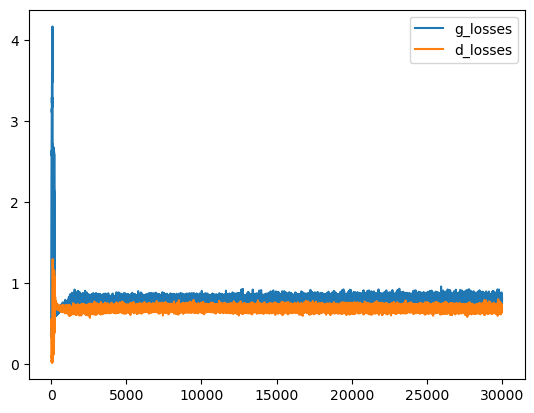

In [26]:
# plot the losses
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()
plt.show()

In [28]:
!dir gan_images

 Volume in drive C is OS
 Volume Serial Number is 58C1-98B9

 Directory of C:\Users\Asus\Documents\tensorflow_2_0_deep_learning_and_artificial_intelligence\10_gan\gan_images

08/01/2024  09:32 PM    <DIR>          .
08/01/2024  09:35 PM    <DIR>          ..
08/01/2024  08:50 PM           201,826 0.png
08/01/2024  08:52 PM           148,300 1000.png
08/01/2024  09:08 PM            90,861 10000.png
08/01/2024  09:08 PM            86,332 10200.png
08/01/2024  09:08 PM            93,943 10400.png
08/01/2024  09:08 PM            89,549 10600.png
08/01/2024  09:09 PM            97,695 10800.png
08/01/2024  09:09 PM            92,074 11000.png
08/01/2024  09:09 PM            91,413 11200.png
08/01/2024  09:09 PM            90,177 11400.png
08/01/2024  09:10 PM            93,212 11600.png
08/01/2024  09:10 PM            85,394 11800.png
08/01/2024  08:52 PM           149,351 1200.png
08/01/2024  09:10 PM            98,722 12000.png
08/01/2024  09:10 PM            97,717 12200.png
08/01/2024  0

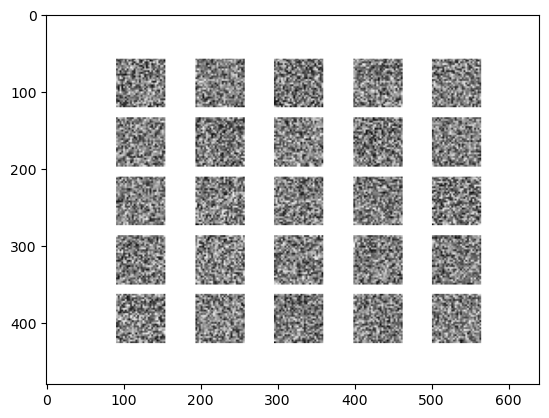

In [29]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

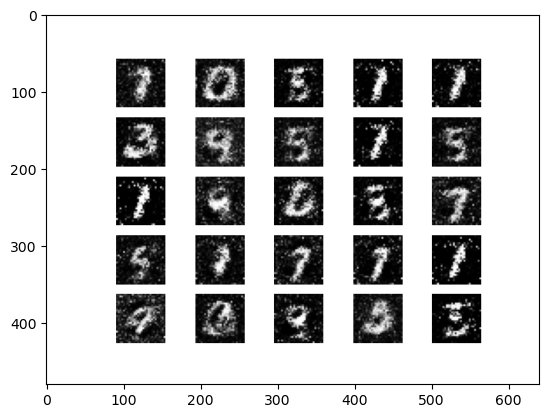

In [30]:
a = imread('gan_images/1000.png')
plt.imshow(a)

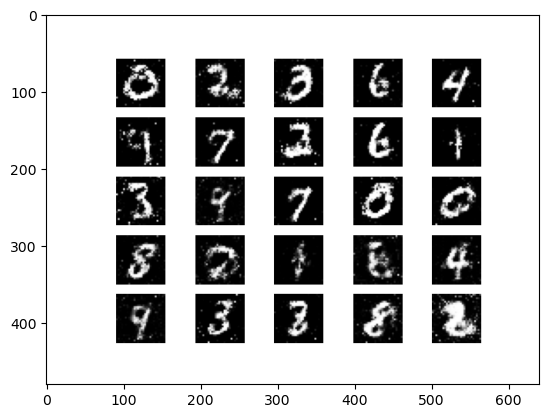

In [31]:
a = imread('gan_images/5000.png')
plt.imshow(a)

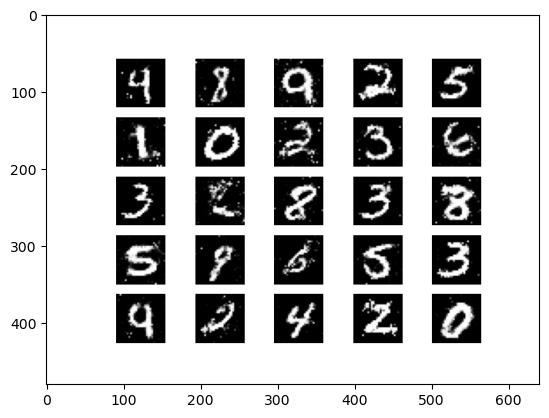

In [32]:
a = imread('gan_images/29800.png')
plt.imshow(a)

In [33]:
combined_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_1 (Functional)        (None, 784)               1493520   
                                                                 
 model (Functional)          (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [34]:
combined_model.save('gan_mnist.h5')